In [22]:
#perform all required imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

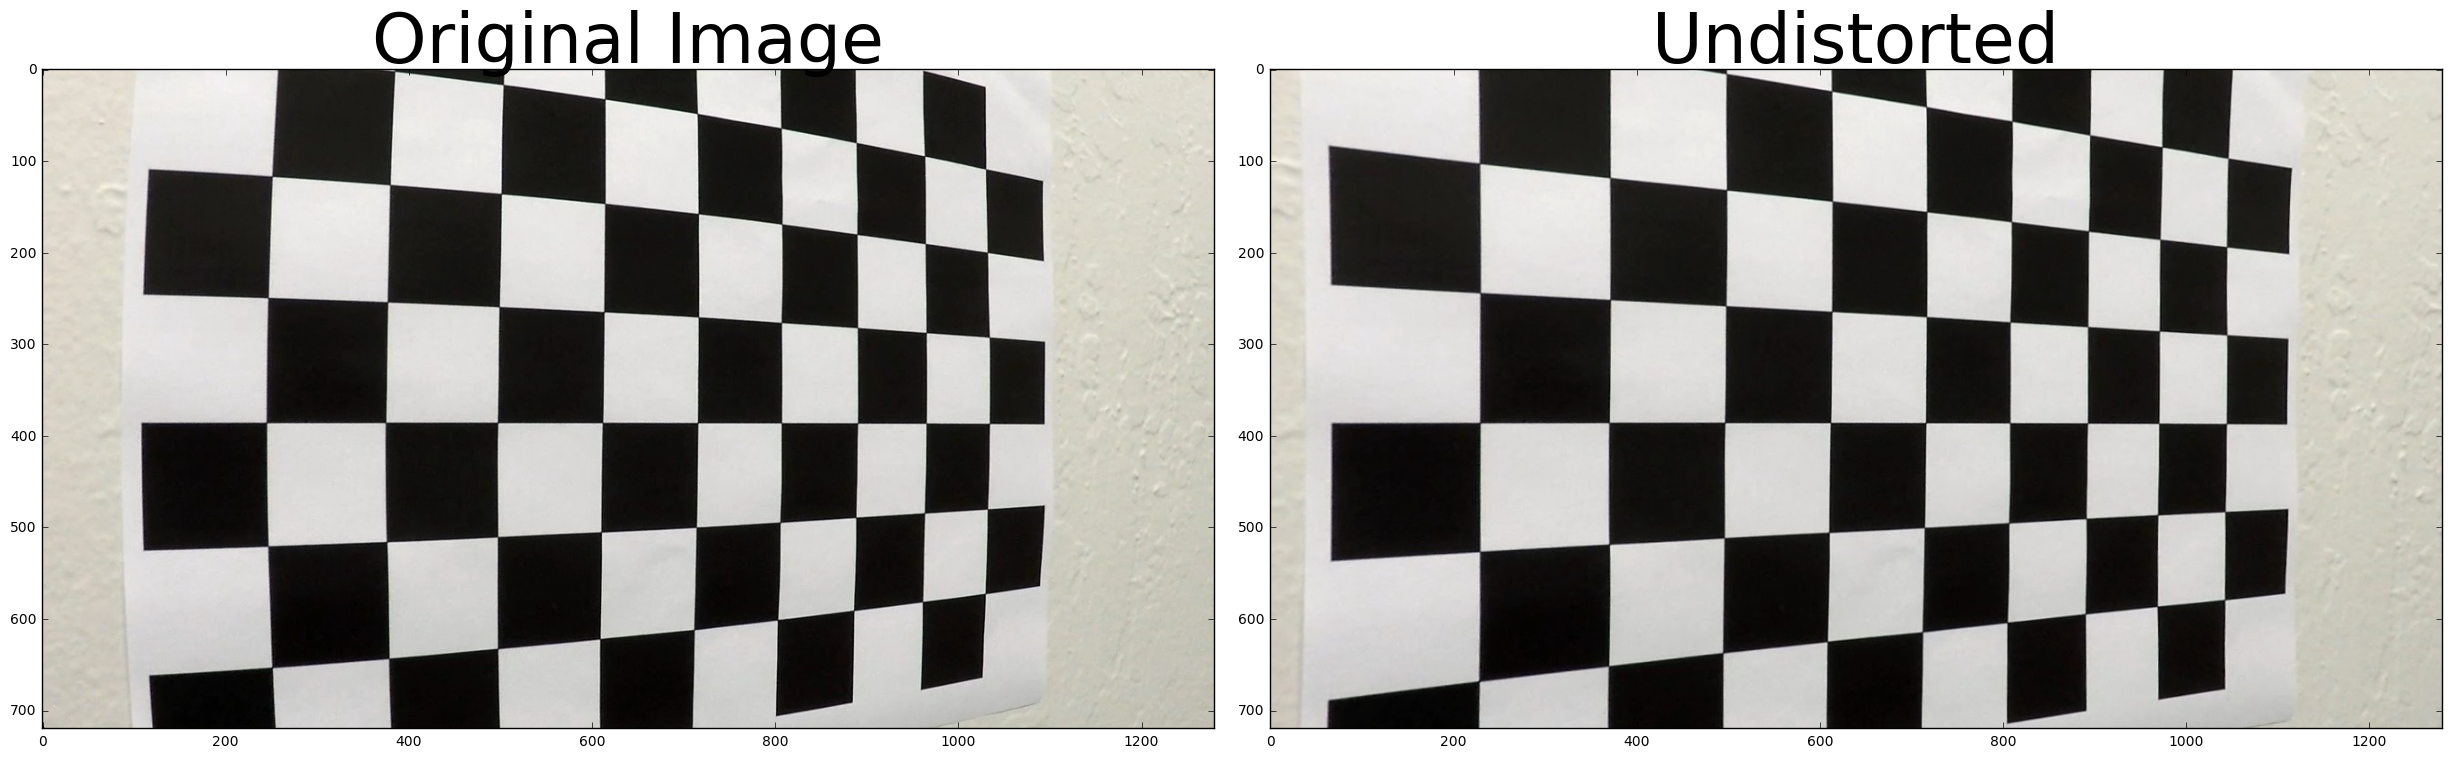

In [23]:
################### Camera calibration routine #################
objpoints=[] # 3D points in real world space
imgpoints=[] # 2D points in image plane
nx=9
ny=6
leftx=[]
lefty=[] 
rightx=[]
righty=[] 
left_fit=[]
right_fit=[]
ploty=[]
left_fitx=[]
right_fitx=[]
left_curverad=0.0
right_curverad=0.0
Offset_Meters=0
image_count=0
Prev_Left_Good_Fit=[]
Prev_Left_Good_Fit=[]
Left_Good_Pix_Count=0
Right_Good_Pix_Count=0
left_Smooth_Count=0
right_Smooth_Count=0
rightx_base=0
leftx_base=0
left_Param_A=[]
left_Param_B=[]
left_Param_C=[]
right_Param_A=[]
right_Param_B=[]
right_Param_C=[]

images=glob.glob('camera_cal/calibration*.jpg')
#prepare object points, like (0,0,0), 1,0,0)....
objp=np.zeros((nx*ny,3),np.float32)

objp[:,:2]=np.mgrid[0:nx,0:ny].T.reshape(-1,2)

for fname in images:
    # read in each image
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
   
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        # Draw and display the corners
        #cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        #plt.imshow(img)

#Calibrate the camera        
ret, mtx, dist, rvecs, tvecs=cv2.calibrateCamera(objpoints,imgpoints,img.shape[0:2],None,None)

# test an image for undistortion
orig_img=mpimg.imread('camera_cal/calibration5.jpg')
undist_img = cv2.undistort(orig_img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(orig_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_img)
ax2.set_title('Undistorted' , fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

################## Calculate perspective & Inverse perspective matrix ##################

# For source points I'm grabbing the outer four detected corners
corners=np.zeros((4,2),np.float32)
corners=[[600,450],[725,450],[1130,680],[250,680]]
#corners=[[560,435],[616,430],[1230,650],[350,650]]
src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    
# For destination points, I'm arbitrarily choosing some points to be
# a nice fit for displaying our warped result 
# again, not exact, but close enough for our purposes
dst = np.float32([[250,0], [1130, 0], [1130,720], [250,720]])
#dst = np.float32([[340,0], [1230, 0], [1230,720], [340,720]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

In [24]:
def Color_Gradient_Threshold(img,display=True):
    #Gradient Threshold code
    #img=mpimg.imread('test_images/test5.jpg')

    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 100
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.stack(( np.zeros_like(sxbinary), sxbinary, s_binary),axis=2)
    #print(color_binary.shape,img.shape)
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    if(display==True):
        # Plotting thresholded images
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Stacked thresholds')
        ax1.imshow(color_binary*255)

        ax2.set_title('Combined S channel and gradient thresholds')
        ax2.imshow(combined_binary, cmap='gray')
    
    return combined_binary


In [25]:
def Detect_Left_and_right_Lane(binary_warped,Display=True):
    global leftx
    global lefty 
    global rightx
    global righty 
    global left_fit
    global right_fit
    global ploty
    global left_fitx
    global right_fitx
    global left_curverad
    global right_curverad
    global Prev_Left_Good_Fit
    global Prev_Right_Good_Fit
    global Left_Good_Pix_Count
    global Right_Good_Pix_Count
    global left_Smooth_Count
    global right_Smooth_Count
    global left_Param_A
    global left_Param_B
    global left_Param_C
    global right_Param_A
    global right_Param_B
    global right_Param_C
    global rightx_base
    global leftx_base
    global Offset_Meters
    
    Left_Good_Pix_Count=0
    Right_Good_Pix_Count=0
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #print(histogram.shape)
    #plt.plot(histogram)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            Left_Good_Pix_Count+=1
           
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            Right_Good_Pix_Count+=1
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    #print("left_lane_inds",left_lane_inds.size)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    #print('From Here ',lefty.shape)
    # Fit a second order polynomial to each
    
    if(Left_Good_Pix_Count<=6):
        left_fit=Prev_Left_Good_Fit
    else:    
        left_fit = np.polyfit(lefty, leftx, 2)
        left_Param_A.append(left_fit[0])
        left_Param_B.append(left_fit[1])
        left_Param_C.append(left_fit[2])
        if(len(left_Param_A)>=10):
            left_fit[0]=np.mean(left_Param_A[-10:])
            left_fit[1]=np.mean(left_Param_B[-10:])
            left_fit[2]=np.mean(left_Param_C[-10:])
        Prev_Left_Good_Fit=left_fit

        
    if(Right_Good_Pix_Count<=6):
        right_fit=Prev_Right_Good_Fit
    else:    
        right_fit = np.polyfit(righty, rightx, 2)
        right_Param_A.append(right_fit[0])
        right_Param_B.append(right_fit[1])
        right_Param_C.append(right_fit[2])
        if(len(right_Param_A)>=10):
            right_fit[0]=np.mean(right_Param_A[-10:])
            right_fit[1]=np.mean(right_Param_B[-10:])
            right_fit[2]=np.mean(right_Param_C[-10:])
        Prev_Right_Good_Fit=right_fit
     
        
    
    #Calculate offset from center of the lane
    Actual_Center=(leftx_base+rightx_base)/2
    Lane_width_Pixels=(rightx_base-leftx_base)
    Offset_Pixels =abs(Actual_Center-(1280/2))
    Offset_Meters=(3.7/Lane_width_Pixels)*Offset_Pixels
   
    
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if(Display==True):
        print('Lane width in pixels : ',(rightx_base-leftx_base))
        print('Offset pixels : ',Offset_Pixels)
        print('Offset Meters : ',Offset_Meters)
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

############## Calculate radius of curvature #####################
def Calculate_Radius_of_Curvature(binary_warped,Display=True):
    global leftx
    global lefty 
    global rightx
    global righty 
    global left_fit
    global right_fit
    global ploty
    global left_fitx
    global right_fitx
    global left_curverad
    global right_curverad
    global rightx_base
    global leftx_base

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/(rightx_base-leftx_base) # meters per pixel in x dimension
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    if(Display==True):
        # Now our radius of curvature is in meters
        print(left_curverad, 'm', right_curverad, 'm')

####### Draw lane lines on the road #######################
def Display_Lane_Lines_Road(binary_warped,img,undist_img,Display=True):
    global leftx
    global lefty 
    global rightx
    global righty 
    global left_fit
    global right_fit
    global ploty
    global left_fitx
    global right_fitx
    global left_curverad
    global right_curverad
    global Offset_Meters
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    str_curvature="Radius of curvature, Left : "+str(round(left_curverad,3))+" m"+" Right : "+str(round(right_curverad,3))+" m"
    str_offset="Offset from lane center : "+str(round(Offset_Meters,3))
    cv2.putText(result,str_curvature, (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, 255)
    cv2.putText(result,str_offset, (50,150), cv2.FONT_HERSHEY_SIMPLEX, 1, 255)
    
    if(Display==True):
        plt.imshow(result)
    return result


original Image shape (720, 1280, 3)
Lane width in pixels :  761
Offset pixels :  53.5
Offset Meters :  0.26011826544
390.958229479 m 688.711773108 m


array([[[105, 147, 187],
        [105, 147, 187],
        [105, 147, 187],
        ..., 
        [ 77, 128, 175],
        [ 78, 127, 175],
        [ 80, 128, 176]],

       [[105, 147, 187],
        [105, 147, 187],
        [105, 147, 187],
        ..., 
        [ 78, 128, 175],
        [ 79, 127, 175],
        [ 81, 129, 177]],

       [[106, 148, 188],
        [105, 147, 187],
        [105, 147, 187],
        ..., 
        [ 79, 127, 175],
        [ 79, 127, 175],
        [ 81, 129, 177]],

       ..., 
       [[104,  87, 103],
        [104,  87, 103],
        [104,  87, 103],
        ..., 
        [112,  89,  81],
        [115,  92,  84],
        [116,  93,  85]],

       [[107,  89, 104],
        [107,  89, 103],
        [106,  88, 102],
        ..., 
        [113,  91,  81],
        [118,  96,  85],
        [120,  98,  88]],

       [[108,  89, 102],
        [108,  89, 101],
        [106,  88,  99],
        ..., 
        [110,  89,  80],
        [112,  91,  82],
        [115,  95,

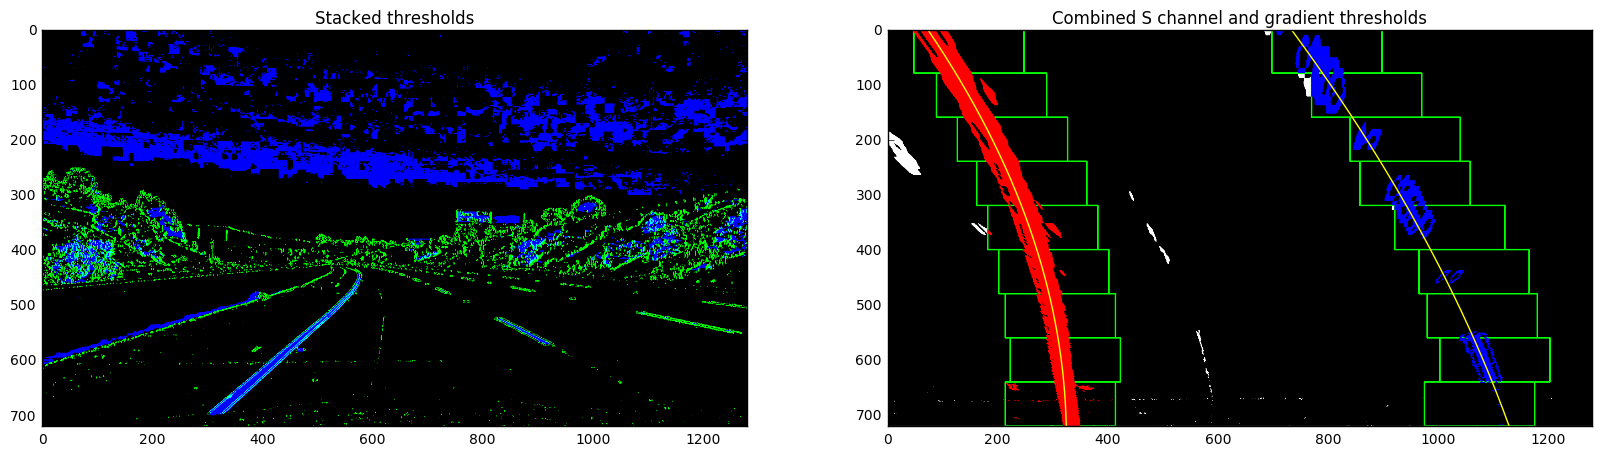

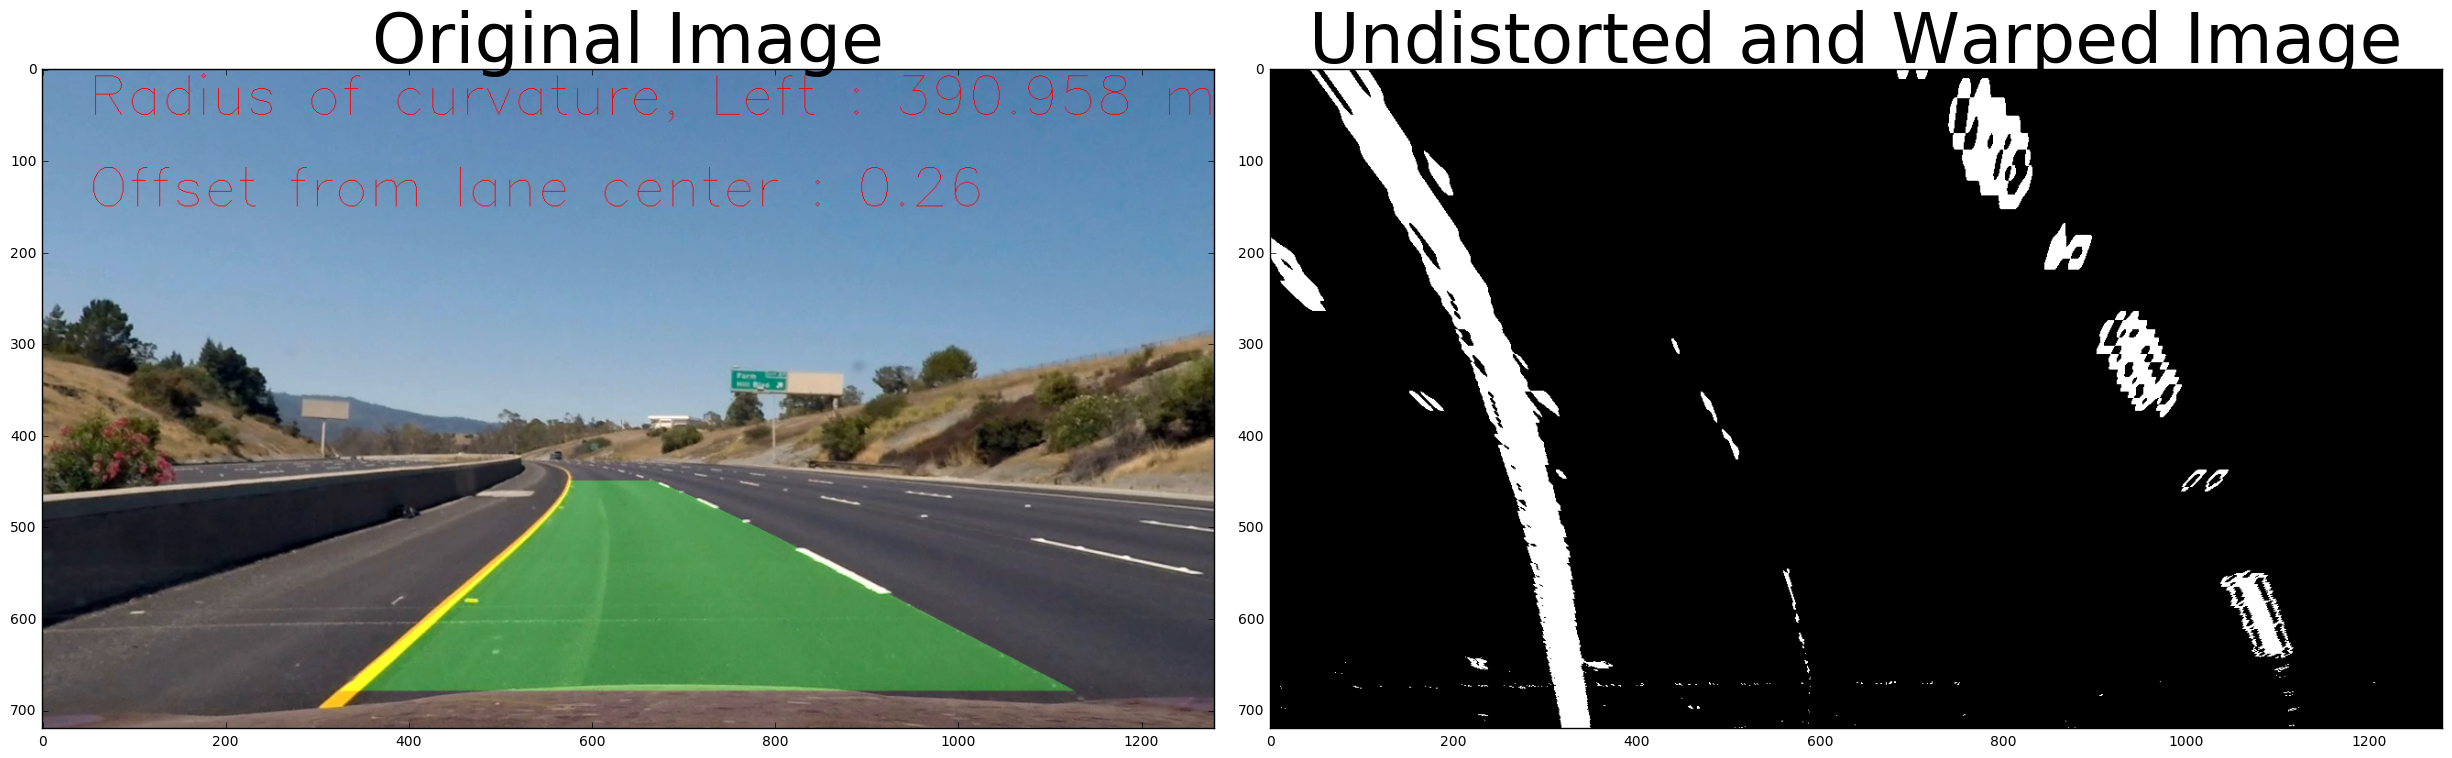

In [21]:
def Process_Image_old(image):
    global image_count

    #Test undistortion & unwarp
    img=mpimg.imread(image)
    print('original Image shape',img.shape)
    image_count+=1
        
   
    # Use the OpenCV undistort() function to remove distortion
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    #print('undistorted Image shape',undist_img.shape)

    #Apply gradient and color thresholding
    GC_thld_img=Color_Gradient_Threshold(undist_img,display=True)
    #print("Gradient Threshold Image Shape",GC_thld_img.shape)
    
   
    #Perform perspective transformation
    Binary_warped_img=cv2.warpPerspective(GC_thld_img, M, (GC_thld_img.shape[1],GC_thld_img.shape[0]))
    #print("Warped Image Shape",Binary_warped_img.shape)

    
    ### Detect the left and right lane in the warped image ####
    Detect_Left_and_right_Lane(Binary_warped_img,Display=True)
    
    #print('From Here 222',lefty.shape)
    
    Calculate_Radius_of_Curvature(Binary_warped_img,Display=True)
    
    result=Display_Lane_Lines_Road(Binary_warped_img,img,undist_img,Display=False)

    
    Warped_Display=True
    #Code to display the
    if (Warped_Display == True):
        RGBimg=cv2.cvtColor(GC_thld_img,cv2.COLOR_GRAY2RGB)
        RGBimg=RGBimg*255
        Line_img=np.zeros_like(RGBimg)
        Top_Left_Corner = (600,450)
        Top_Right_Corner =(725,450)
        Bottom_Right_Corner =(1130,680)
        Bottom_Left_Corner =(250,680)

        cv2.line(Line_img, Top_Left_Corner, Top_Right_Corner, (255,0,0), 1)
        cv2.line(Line_img, Top_Right_Corner, Bottom_Right_Corner, (255,0,0), 1)
        cv2.line(Line_img, Bottom_Right_Corner, Bottom_Left_Corner, (255,0,0), 1)
        cv2.line(Line_img, Bottom_Left_Corner, Top_Left_Corner, (255,0,0), 1)
        Final_img=cv2.addWeighted(src1=RGBimg,alpha=0.2, src2=Line_img,beta=0.8,gamma=0.0)


        #print("warped_img.shape",Binary_warped_img.shape)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(result)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(Binary_warped_img,cmap='gray')
        ax2.set_title('Undistorted and Warped Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

       # print('binary_warped',binary_warped.shape[0]//2)
    return result
Process_Image_old('IMG_ProjectVideo/1Orig_img.jpg')
#Process_Image_old('test_images/test5.jpg')

In [26]:
def Process_Image(img):
    global image_count

    #Test undistortion & unwarp
    ##img=mpimg.imread(image)
    ##print('original Image shape',img.shape)
    image_count+=1
    Image_Save=True
    if(Image_Save==True):
        Filename= "./IMG/"+str(image_count)+ "Orig_img"+".jpg"
        mpimg.imsave(Filename,img)
    
    # Use the OpenCV undistort() function to remove distortion
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    #print('undistorted Image shape',undist_img.shape)

    #Apply gradient and color thresholding
    GC_thld_img=Color_Gradient_Threshold(undist_img,display=False)
    #print("Gradient Threshold Image Shape",GC_thld_img.shape)
    if(Image_Save==True):
        Filename= "./IMG/"+str(image_count)+ "GC_thld_img"+".jpg"
        mpimg.imsave(Filename,np.dstack((GC_thld_img, GC_thld_img, GC_thld_img))*255)
    
    #Perform perspective transformation
    Binary_warped_img=cv2.warpPerspective(GC_thld_img, M, (GC_thld_img.shape[1],GC_thld_img.shape[0]))
    #print("Warped Image Shape",Binary_warped_img.shape)
    if(Image_Save==True):
        Filename= "./IMG/"+str(image_count)+ "Binary_warped_img"+".jpg"
        mpimg.imsave(Filename,np.dstack((Binary_warped_img, Binary_warped_img, Binary_warped_img))*255)
    
    
    ### Detect the left and right lane in the warped image ####
    Detect_Left_and_right_Lane(Binary_warped_img,Display=False)
    
    #print('From Here 222',lefty.shape)
    
    Calculate_Radius_of_Curvature(Binary_warped_img,Display=False)
    
    result=Display_Lane_Lines_Road(Binary_warped_img,img,undist_img,Display=False)
    if(Image_Save==True):
        Filename= "./IMG/"+str(image_count)+ "result"+".jpg"
        mpimg.imsave(Filename,result)
    
    Warped_Display=False
    #Code to display the
    if (Warped_Display == True):
        RGBimg=cv2.cvtColor(GC_thld_img,cv2.COLOR_GRAY2RGB)
        RGBimg=RGBimg*255
        Line_img=np.zeros_like(RGBimg)
        Top_Left_Corner = (600,450)
        Top_Right_Corner =(725,450)
        Bottom_Right_Corner =(1130,680)
        Bottom_Left_Corner =(250,680)

        cv2.line(Line_img, Top_Left_Corner, Top_Right_Corner, (255,0,0), 1)
        cv2.line(Line_img, Top_Right_Corner, Bottom_Right_Corner, (255,0,0), 1)
        cv2.line(Line_img, Bottom_Right_Corner, Bottom_Left_Corner, (255,0,0), 1)
        cv2.line(Line_img, Bottom_Left_Corner, Top_Left_Corner, (255,0,0), 1)
        Final_img=cv2.addWeighted(src1=RGBimg,alpha=0.2, src2=Line_img,beta=0.8,gamma=0.0)


        #print("warped_img.shape",Binary_warped_img.shape)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(Final_img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(Binary_warped_img,cmap='gray')
        ax2.set_title('Undistorted and Warped Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

       # print('binary_warped',binary_warped.shape[0]//2)
    return result


## Import Packages

In [ ]:
#Process_Image('test_images/test5.jpg')

## Read in an Image

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [29]:
Output = 'Output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(Process_Image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(Output, audio=False)

[MoviePy] >>>> Building video Output.mp4
[MoviePy] Writing video Output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [08:37<00:00,  2.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Output.mp4 

Wall time: 8min 38s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(Output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))